In [6]:
# Import standard libraries
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MonthLocator
import seaborn as sns
import warnings
import requests
import itertools

# Import data analysis and signal processing libraries
from scipy.stats import mstats
from scipy.signal import argrelextrema
from tqdm import tqdm, tnrange, notebook
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# Import asynchronous libraries
import asyncio
import aiohttp

# Import machine learning libraries
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras import callbacks
import talib
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# Import Backtesting library
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

# Set seaborn style
sns.set()

# Filter out warnings
warnings.filterwarnings("ignore")


# Importing data and creating train-test split

In [7]:
prices = pd.read_csv('./coin_data.csv', index_col=0)
prices = prices.astype(float)
prices.index = pd.to_datetime(prices.index)

split = int(len(prices)*0.8)
train_prices = prices[:split]
test_prices = prices[split:]

# Choosing cointegrated pair

       scores   pvalues                  pairs
102 -4.182042  0.003883  (DOGEUSDT, MATICUSDT)
39  -4.176122  0.003964     (DOTUSDT, CRVUSDT)
14  -3.558762  0.027530    (XMRUSDT, AAVEUSDT)
19  -3.445207  0.037572     (XMRUSDT, UNIUSDT)
90  -3.371645  0.045599     (BNBUSDT, ADAUSDT)


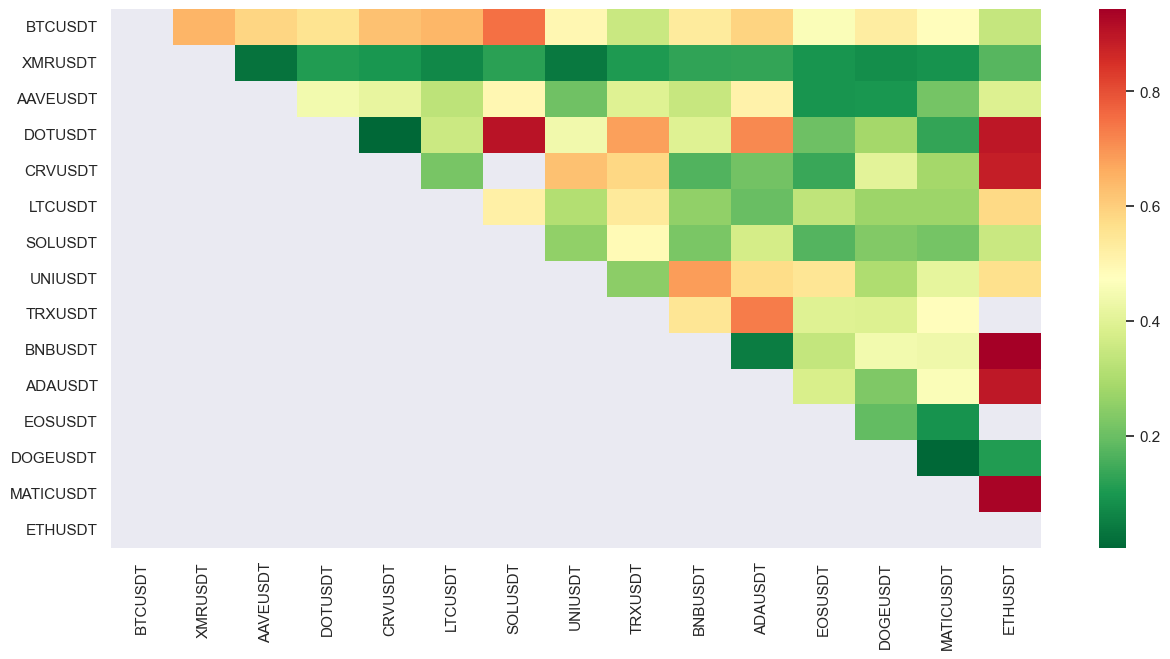

In [8]:
def find_cointegrated_pairs(data, conf=0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < conf:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

# used vectorization
def find_cointegrated_pairs_v3(data, conf=0.05):
    n = data.shape[1]
    keys = data.columns
    pairs = []
    scores = np.zeros((n * (n - 1)) // 2)  # Initialize as a 1D NumPy array
    pvalues = np.ones((n * (n - 1)) // 2)  # Initialize as a 1D NumPy array
    
    idx = 0  # Index for storing results in the arrays
    
    for i in range(n):
        for j in range(i + 1, n):
            S1 = data[keys[i]].values  # Convert to NumPy array
            S2 = data[keys[j]].values  # Convert to NumPy array
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            
            scores[idx] = score
            pvalues[idx] = pvalue
            pairs.append((keys[i], keys[j]))
            
            idx += 1
    
    coint_pairs = pd.DataFrame({'scores': scores, 'pvalues': pvalues, 'pairs': pairs})
    coint_pairs = coint_pairs[coint_pairs['pvalues'] < conf]
    
    return coint_pairs.sort_values('pvalues')

# Usage example
scores, pvalues, pairs = find_cointegrated_pairs(train_prices)
cointegrated_pairs = find_cointegrated_pairs_v3(train_prices)
print(cointegrated_pairs)

plt.figure(figsize=(15,7))

sns.heatmap(pvalues, xticklabels=prices.columns, 
                yticklabels=prices.columns, cmap='RdYlGn_r', 
                mask = (pvalues >= 0.95))

plt.show()


In [9]:
pair = cointegrated_pairs.iloc[0]['pairs']
P1 = pair[0]
P2 = pair[1]
print('Best pair: ', P1, P2)

Best pair:  DOGEUSDT MATICUSDT


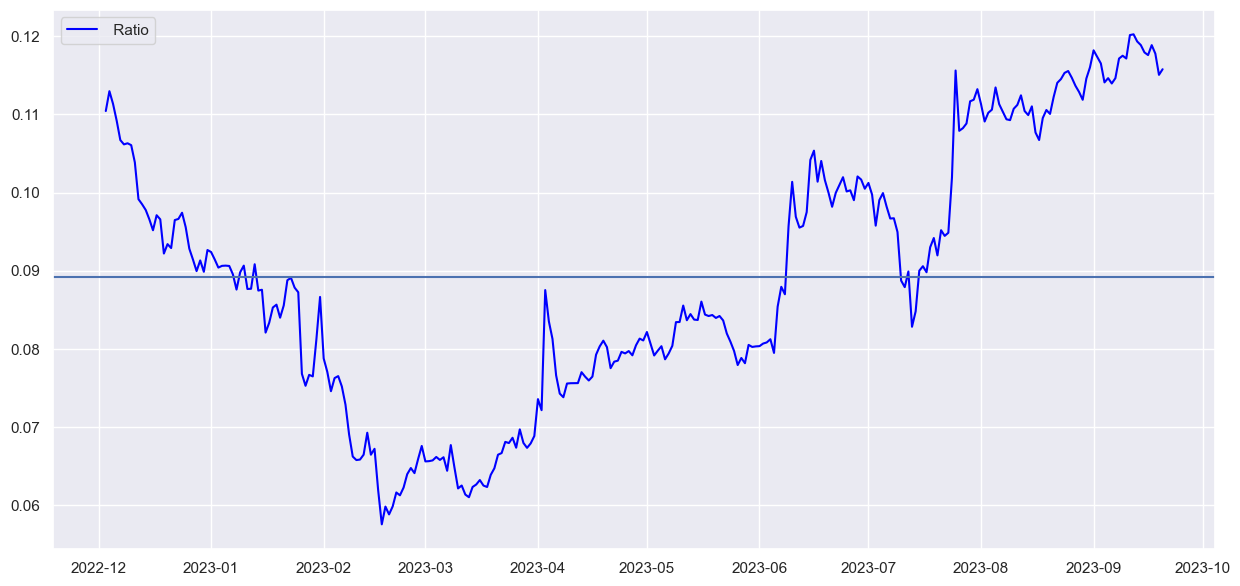

Mean ratio (DOGEUSDT/MATICUSDT): 0.0891


In [10]:
# Finding the ratio for DOGE / MATIC

S1 = train_prices[P1]
S2 = train_prices[P2]

score, pvalue, _ = coint(S1, S2)
ratios = S1 / S2

plt.figure(figsize=(15,7))

plt.plot(ratios.index, ratios, color='blue')
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()

print(f'Mean ratio ({P1}/{P2}): {ratios.mean():.4f}')

# Backtesting

In [11]:
def trade(P1, P2, near, far, initial_capital=10000, commission_rate=0.01, test=False, verbose=False):
    if (near == 0) or (far == 0) or (near >= far):
        return 0

    if test:
        if verbose:
            print('Trade on Testing Data\n')
        price1 = test_prices[P1]
        price2 = test_prices[P2]
    else:
        if verbose:
            print('Trade on Training Data\n')
        price1 = train_prices[P1]
        price2 = train_prices[P2]

    ratios = price1 / price2
    ma1 = ratios.rolling(window=near, center=False).mean()
    ma2 = ratios.rolling(window=far, center=False).mean()
    std = ratios.rolling(window=far, center=False).std()
    zscore = (ma1 - ma2) / std

    money = initial_capital
    countS1 = 0
    countS2 = 0
    drawdown = 0
    transactions = []
    
    # Store prices in variables to avoid redundant access
    prices1 = price1.values
    prices2 = price2.values

    for i in range(len(ratios)):
        capital_per_asset = money / 2
        qty1 = capital_per_asset // prices1[i]
        qty2 = capital_per_asset // prices2[i]
        
        # Calculate the commission for buying or selling
        def calculate_commission(price, quantity):
            return price * quantity * commission_rate

        transaction_value1 = qty1 * prices1[i]
        transaction_value2 = qty2 * prices2[i]
        commission = calculate_commission(prices1[i], qty1) + calculate_commission(prices2[i], qty2)

        # Sell short P1 and long P2 if z-score > 1
        if zscore[i] < -1 and countS1 == 0 and countS2 == 0:
            money += transaction_value1 - transaction_value2 - commission
            countS1 -= qty1
            countS2 += qty2
            opendatetime = ratios.index[i]
            transactions.append(logTxn(opendatetime, 'Sell', P1, prices1[i], qty1,
                                       'Buy', P2, prices2[i], qty2, zscore[i], 1, money))

        # Buy long P1 and short P2 if z-score < -1
        elif zscore[i] > 1 and countS1 == 0 and countS2 == 0:
            money -= transaction_value1 - transaction_value2 + commission
            countS1 += qty1
            countS2 -= qty2
            opendatetime = ratios.index[i]
            transactions.append(logTxn(opendatetime, 'Buy', P1, prices1[i], qty1,
                                       'Sell', P2, prices2[i], qty2, zscore[i], 1, money))

        # Close all positions if z-score between -0.75 and 0.75
        elif abs(zscore[i]) < 0.75 and (countS1 != 0 or countS2 != 0):
            transaction_value1 = countS1 * prices1[i]
            transaction_value2 = countS2 * prices2[i]
            commission = calculate_commission(prices1[i], abs(countS1)) + calculate_commission(prices2[i], abs(countS2))
            money += transaction_value1 + transaction_value2 - commission
            closedatetime = ratios.index[i]
            holdingperiod = closedatetime - opendatetime
            transactions.append(logTxn(closedatetime, 'Close', P1, prices1[i], countS1,
                                       'Close', P2, prices2[i], countS2, zscore[i], 1, money, drawdown, holdingperiod))
            countS1 = 0
            countS2 = 0
            drawdown = 0

        drawdown = min(money, drawdown)

    return transactions

def logTxn(datetime, action1, coin1, price1, qty1, action2, coin2, price2, qty2, zscore, hedgeratio, pnl, drawdown=0, holdingperiod=timedelta(0)):
    txn = {'datetime': datetime, 'action1': action1, 'coin1': coin1, 'price1': price1, 'qty1': qty1,
           'action2': action2, 'coin2': coin2, 'price2': price2, 'qty2': qty2, 'zscore': zscore,
           'hedgeratio': hedgeratio, 'pnl': pnl, 'drawdown': drawdown, 'holdingperiod': holdingperiod}
    return txn

def showResults(txn):
    
    txn = pd.DataFrame.from_dict(txn)
    txn = txn[['datetime', 'action1', 'coin1', 'price1', 'qty1',
               'action2', 'coin2', 'price2', 'qty2', 
               'zscore', 'hedgeratio', 'pnl', 'drawdown', 'holdingperiod']]
    txn = txn.set_index('datetime')    
    
    plt.figure(figsize=(15,7))
    plt.plot(txn.pnl.index, txn.pnl)    

    ax = plt.gca()
    formatter = DateFormatter("%Y-%m")
    ax.xaxis.set_major_formatter(formatter)
    locator = MonthLocator()
    ax.xaxis.set_major_locator(locator)    
    
    plt.show()

    print('Profit/Loss: {:.2f}'.format(txn.iloc[-1].pnl))
    print('Maximum Drawdown: {:.2f}'.format(min(txn.drawdown)))
    print('Maximum Holding Period: {}'.format(max(txn.holdingperiod)))
    
    return txn

  0%|          | 0/400 [00:00<?, ?it/s]

Best Parameters: Near: 5, Far: 50


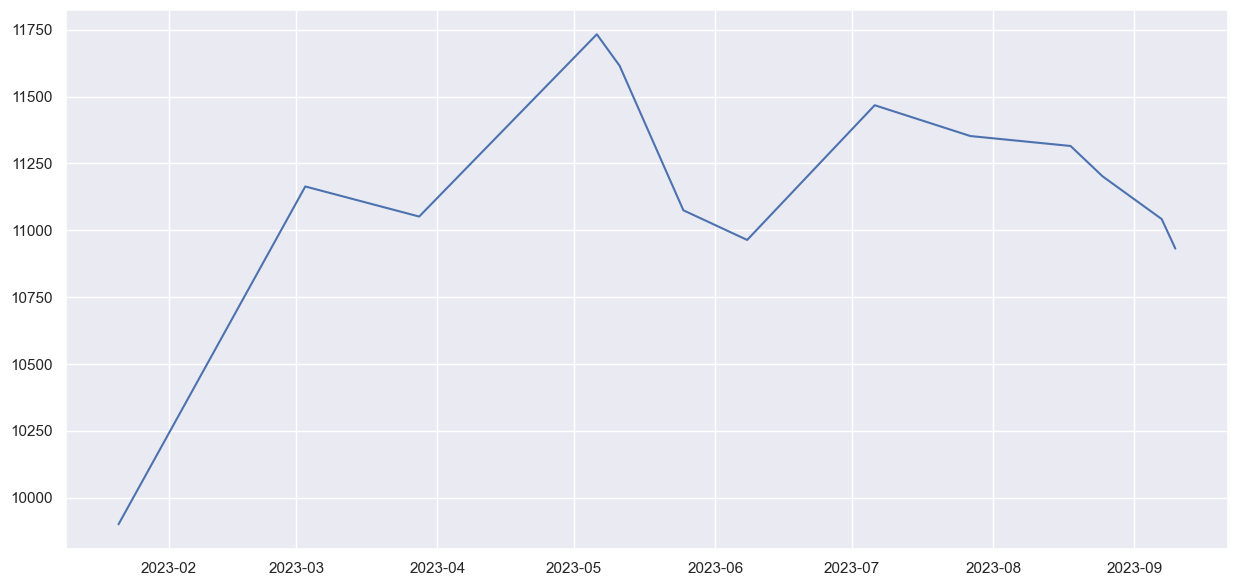

Profit/Loss: 10931.33
Maximum Drawdown: 0.00
Maximum Holding Period: 41 days 00:00:00


,action1,coin1,price1,qty1,action2,coin2,price2,qty2,zscore,hedgeratio,pnl,drawdown,holdingperiod
datetime,,,,,,,,,,,,,
2023-01-21,Sell,DOGEUSDT,0.08467,59052.0,Buy,MATICUSDT,0.9897,5052.0,-1.240850,1,9899.969468,0,0 days
2023-03-03,Close,DOGEUSDT,0.07684,-59052.0,Close,MATICUSDT,1.1690,5052.0,-0.736081,1,11163.768351,0,41 days
2023-03-28,Buy,DOGEUSDT,0.07381,75625.0,Sell,MATICUSDT,1.0860,5139.0,1.129420,1,11051.212748,0,0 days
2023-05-06,Close,DOGEUSDT,0.07672,75625.0,Close,MATICUSDT,0.9753,-5139.0,0.739682,1,11732.955881,0,39 days
2023-05-11,Buy,DOGEUSDT,0.07193,81558.0,Sell,MATICUSDT,0.8409,6976.0,1.044270,1,11615.281488,0,0 days


In [12]:
near = list(range(5,15,1))
far = list(range(50,90,1))

combine = [near,far]
params = list(itertools.product(*combine)) 

search_results = []

for param in notebook.tqdm(params):
    result = {}
    txn = trade(P1, P2, param[0], param[1], commission_rate=0.01)
    
    txn = pd.DataFrame.from_dict(txn)
    txn = txn[['datetime', 'action1', 'coin1', 'price1', 'qty1',
               'action2', 'coin2', 'price2', 'qty2', 
               'zscore', 'hedgeratio', 'pnl', 'drawdown', 'holdingperiod']]
    txn = txn.set_index('datetime')    

    result['parameter'] = param
    result['PnL'] = txn.iloc[-1].pnl
    result['max_drawdown'] = min(txn.drawdown)
    result['score'] = result['PnL']/abs(result['max_drawdown'])
    
    search_results.append(result)

best = pd.DataFrame(search_results).sort_values('score', ascending=False).reset_index().parameter[0]
print('Best Parameters: Near: {}, Far: {}'.format(best[0], best[1]))

txn = trade(P1, P2, best[0], best[1])
train_results = showResults(txn)
train_results.head()
